In [ ]:
!pip install keras

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image                  
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [ ]:
# Pretty display for notebooks
%matplotlib inline

In [ ]:
DATA_DIR = "D:/state-farm-distracted-driver-detection/imgs"
TEST_DIR = os.path.join(DATA_DIR,"test")
TRAIN_DIR = os.path.join(DATA_DIR,"train")
MODEL_PATH = os.path.join(os.getcwd(),"model","self_trained")
PICKLE_DIR = os.path.join(os.getcwd(),"pickle_files")
CSV_DIR = os.path.join(os.getcwd(),"csv_files")

In [ ]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
if not os.path.exists(PICKLE_DIR):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

In [ ]:
def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(os.path.join(os.getcwd(),"csv_files",filename),index=False)

create_csv(TRAIN_DIR,"train.csv")
create_csv(TEST_DIR,"test.csv")
data_train = pd.read_csv(os.path.join(os.getcwd(),"csv_files","train.csv"))
data_test = pd.read_csv(os.path.join(os.getcwd(),"csv_files","test.csv"))

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filename   22424 non-null  object
 1   ClassName  22424 non-null  object
dtypes: object(2)
memory usage: 350.5+ KB


In [ ]:
data_train['ClassName'].value_counts()

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: ClassName, dtype: int64

In [ ]:
data_train.describe()

,Filename,ClassName
count,22424,22424
unique,22424,10
top,D:/state-farm-distracted-driver-detection/imgs...,c0
freq,1,2489


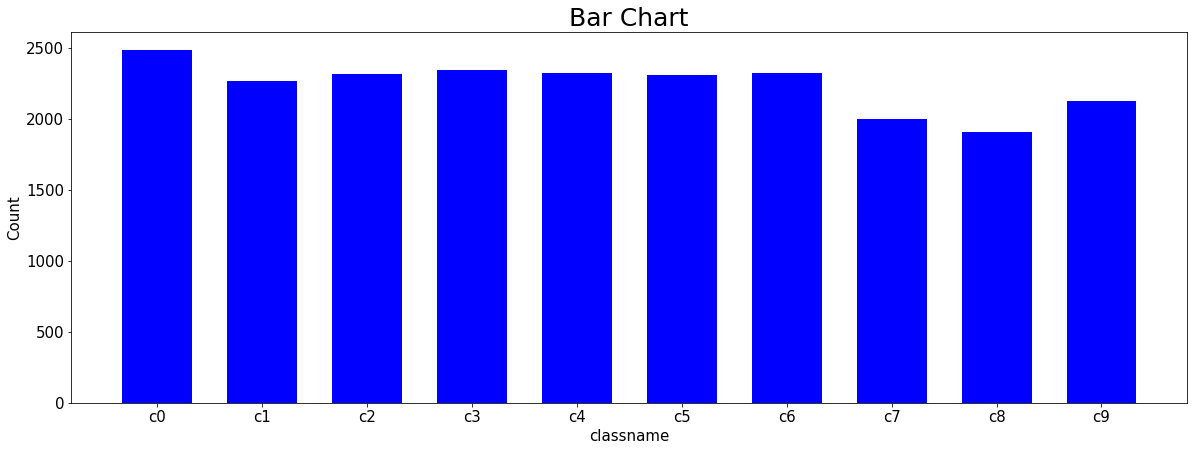

In [ ]:
nf = data_train['ClassName'].value_counts(sort=False)
labels = data_train['ClassName'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()

In [ ]:
data_test.head()

,FileName,ClassName
0,D:/state-farm-distracted-driver-detection/imgs...,test
1,D:/state-farm-distracted-driver-detection/imgs...,test
2,D:/state-farm-distracted-driver-detection/imgs...,test
3,D:/state-farm-distracted-driver-detection/imgs...,test
4,D:/state-farm-distracted-driver-detection/imgs...,test


In [ ]:
data_test.shape

(33524, 2)

In [ ]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'c2': 0, 'c5': 1, 'c1': 2, 'c8': 3, 'c9': 4, 'c6': 5, 'c4': 6, 'c0': 7, 'c3': 8, 'c7': 9}


In [ ]:
labels = to_categorical(data_train['ClassName'])
print(labels.shape)

(22424, 10)


In [ ]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)

In [ ]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 64,64, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)



In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5

100%|███████████████████████████████████████████████████████████████████████████| 17939/17939 [02:52<00:00, 103.88it/s]


In [ ]:
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

100%|█████████████████████████████████████████████████████████████████████████████| 4485/4485 [00:41<00:00, 107.43it/s]


In [ ]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(64,64,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       131328    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 512)         5

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [ ]:
model_history = model.fit(train_tensors,ytrain,validation_data = (valid_tensors, ytest),epochs=25, batch_size=40, shuffle=True,callbacks=callbacks_list)


Epoch 1/25
449/449 [==============================] - 433s 964ms/step - loss: 0.5704 - accuracy: 0.8095 - val_loss: 0.2135 - val_accuracy: 0.9284

Epoch 00001: val_accuracy improved from -inf to 0.92843, saving model to C:\Users\Ayush\model\self_trained\distracted-01-0.93.hdf5
Epoch 2/25
449/449 [==============================] - 438s 976ms/step - loss: 0.1765 - accuracy: 0.9470 - val_loss: 0.1133 - val_accuracy: 0.9674

Epoch 00002: val_accuracy improved from 0.92843 to 0.96745, saving model to C:\Users\Ayush\model\self_trained\distracted-02-0.97.hdf5
Epoch 3/25
449/449 [==============================] - 452s 1s/step - loss: 0.1048 - accuracy: 0.9688 - val_loss: 0.0645 - val_accuracy: 0.9842

Epoch 00003: val_accuracy improved from 0.96745 to 0.98417, saving model to C:\Users\Ayush\model\self_trained\distracted-03-0.98.hdf5
Epoch 4/25
449/449 [==============================] - 443s 985ms/step - loss: 0.0806 - accuracy: 0.9768 - val_loss: 0.0883 - val_accuracy: 0.9781

Epoch 00004: val

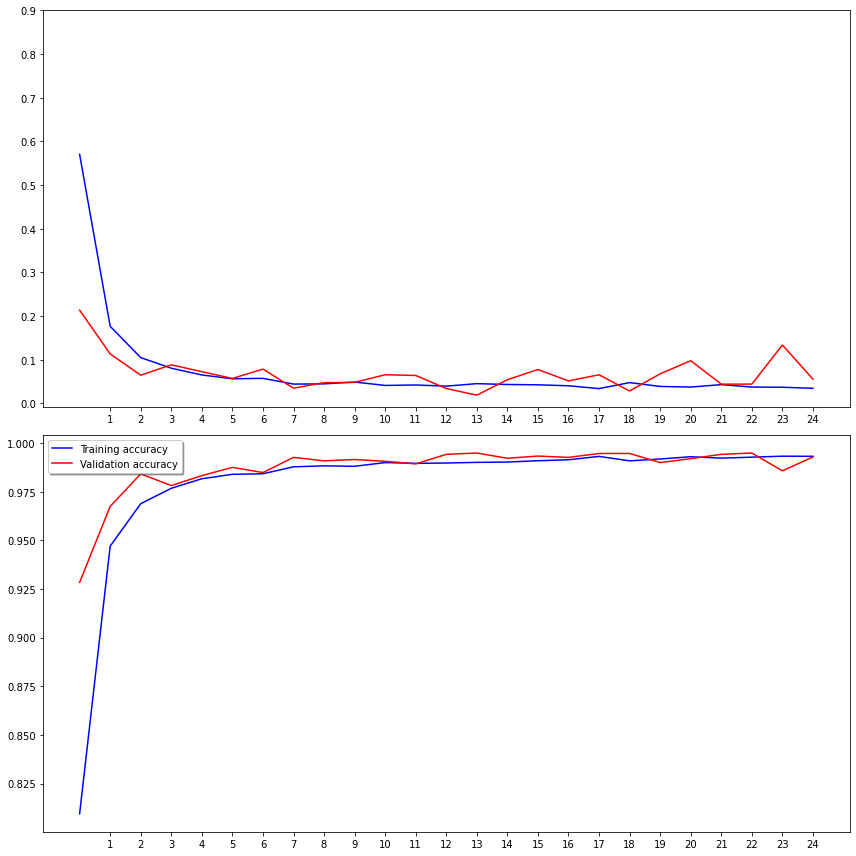

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 25, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 25, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()